In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics
from tasks.boston_housing import make_task4 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names, name_b='C')

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (0, 0)... 0:09:14.142372
- (0, 1)... 0:18:27.901131
- (0, 2)... 0:27:40.599932
- (1, 0)... 0:36:53.883956
- (1, 1)... 0:46:07.664046
- (1, 2)... 0:55:20.979274
- (2, 0)... 1:04:33.389025
- (2, 1)... 1:13:44.625557
- (2, 2)... 1:22:59.605905

## $(0,1)$

In [5]:
focus_class = '(0, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

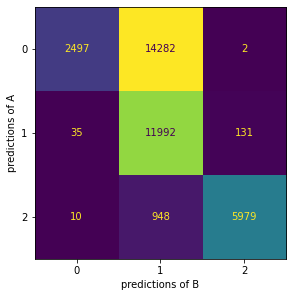

In [8]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-01.pdf')

In [9]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 1min 43s, sys: 1.21 s, total: 1min 45s
Wall time: 2min 5s


405

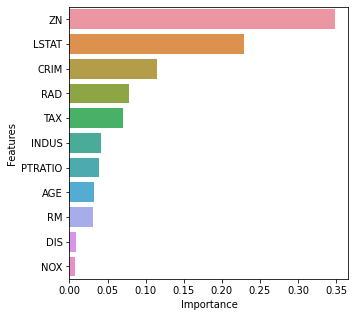

In [10]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

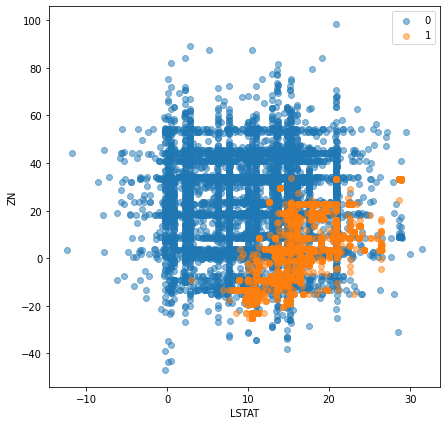

In [11]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [12]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07929222674267628, 1, 2)

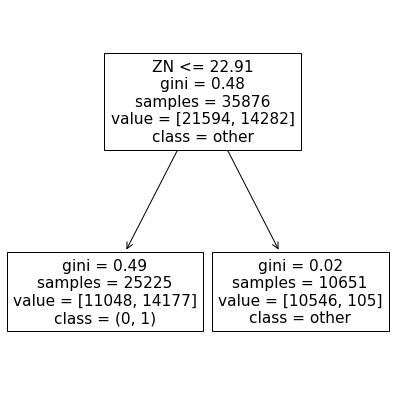

In [13]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [14]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23 => (0, 1) [11048, 14177]


### 4 Leafs

In [15]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01952841542162531, 3, 4)

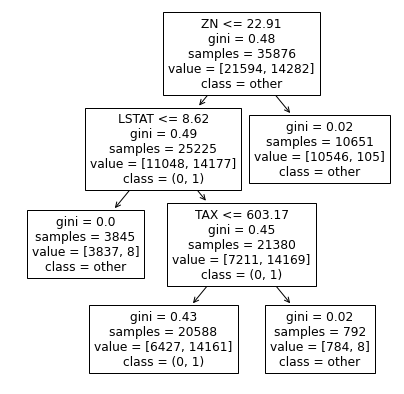

In [16]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [17]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN <= 23 and LSTAT > 8.62 and TAX <= 603 => (0, 1) [6427, 14161]


## $(1,0)$

In [8]:
focus_class = '(1, 0)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [9]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

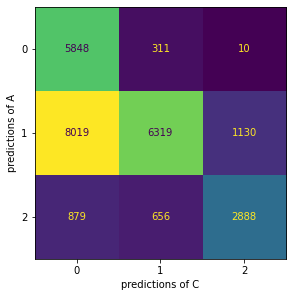

In [10]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-10.pdf')

In [11]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 50.8 s, sys: 306 ms, total: 51.1 s
Wall time: 52.1 s


352

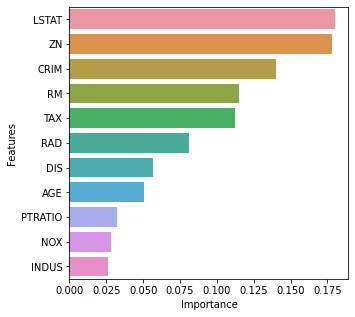

In [12]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

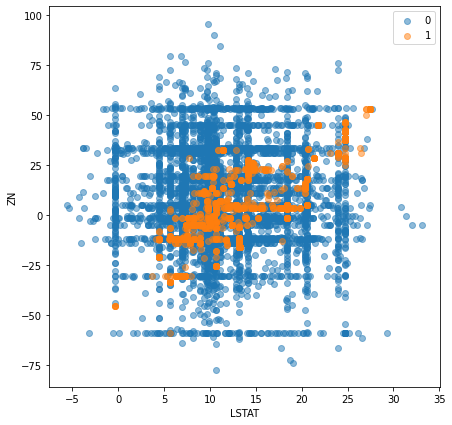

In [13]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [14]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02370747063194481, 1, 2)

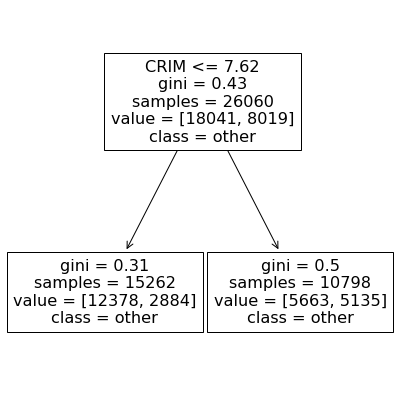

In [15]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [16]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

### 4 Leafs

In [17]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.021560687680527435, 3, 4)

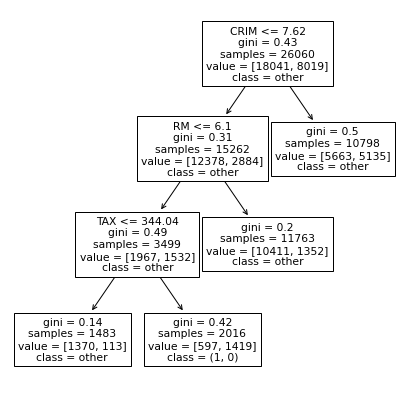

In [18]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [19]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]


### 5 Leafs

In [20]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01929482125314738, 3, 5)

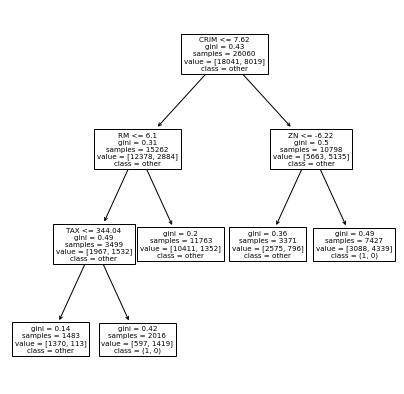

In [21]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [22]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > -6 and CRIM > 7.6 => (1, 0) [3088, 4339]
2. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]


### 6 Leafs

In [23]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01439327372636763, 3, 6)

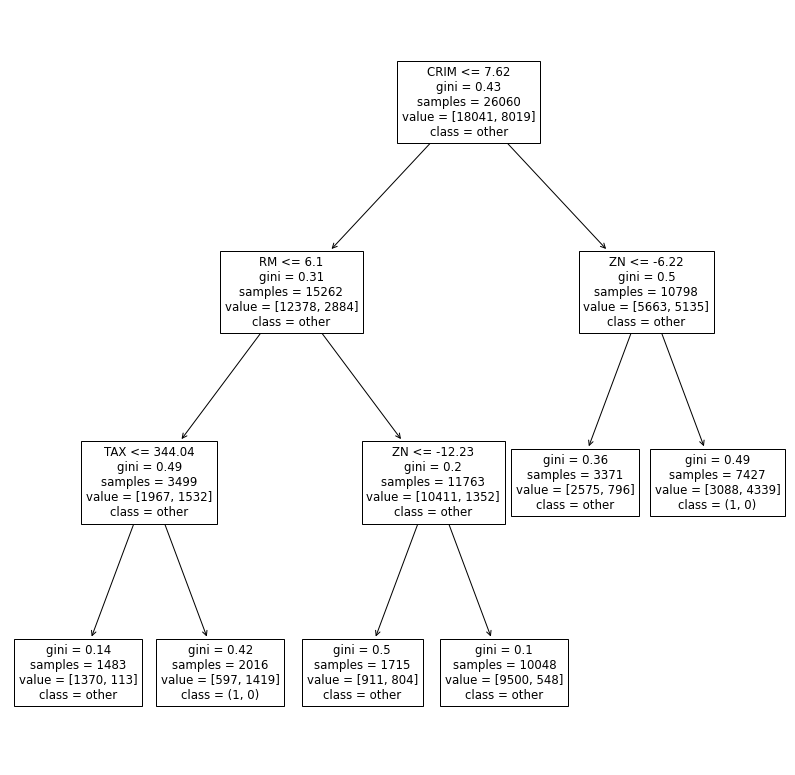

In [26]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [25]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > -6 and CRIM > 7.6 => (1, 0) [3088, 4339]
2. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]


### 7 Leafs

In [27]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013169826943061527, 3, 7)

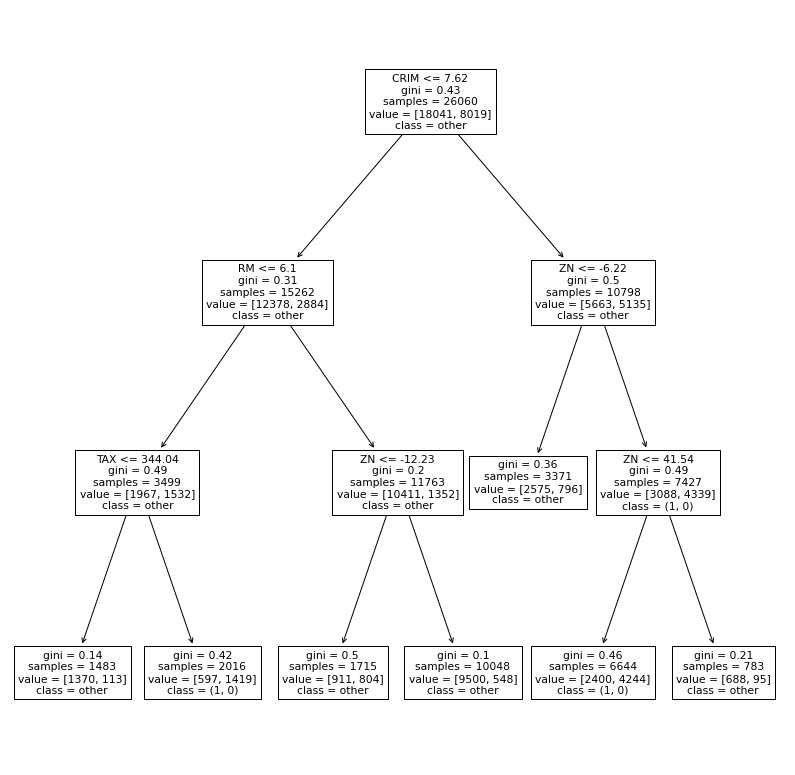

In [28]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [29]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 => (1, 0) [2400, 4244]
2. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]


### 8 Leafs

In [30]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01199368190712019, 3, 8)

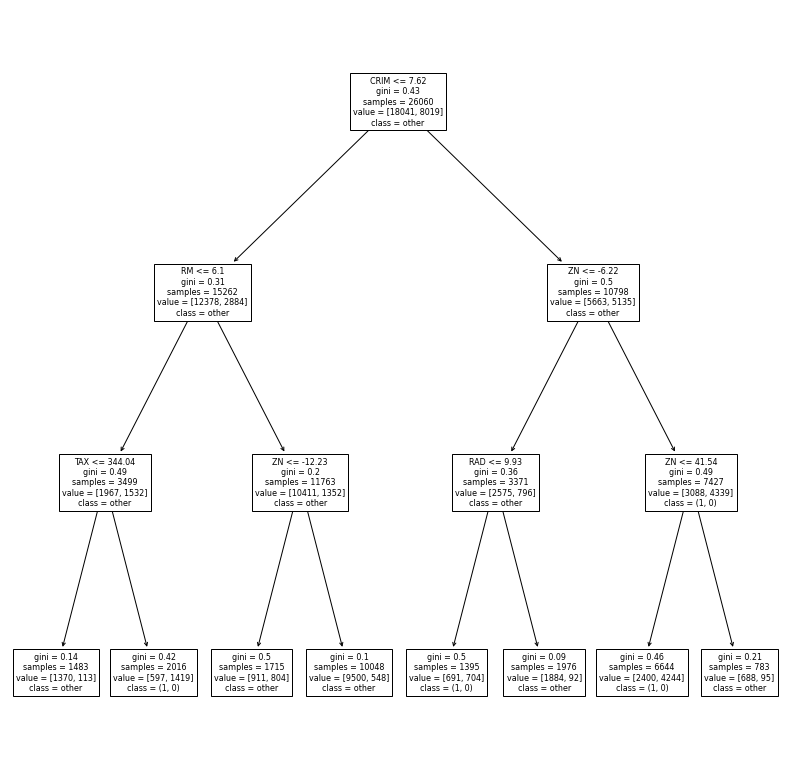

In [31]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [32]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 => (1, 0) [2400, 4244]
2. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
3. ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [691, 704]


### 9 Leafs

In [33]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.010300555079268484, 4, 9)

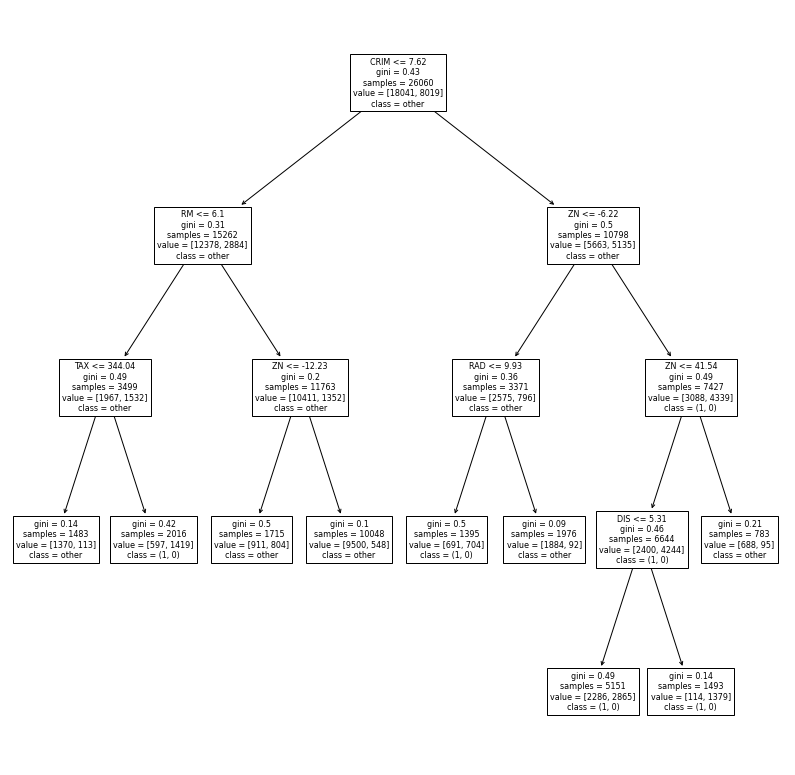

In [34]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [35]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 => (1, 0) [2286, 2865]
2. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [691, 704]


### 10 Leafs

In [36]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.008862089991066812, 5, 10)

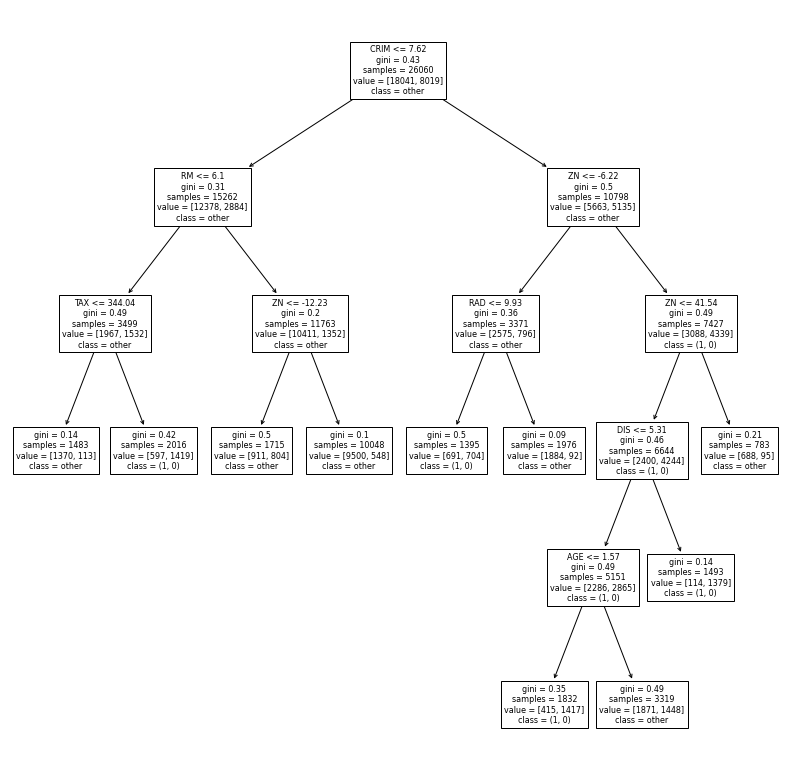

In [37]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [38]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
2. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [691, 704]


### 12 Leafs

In [39]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007727299222721785, 7, 12)

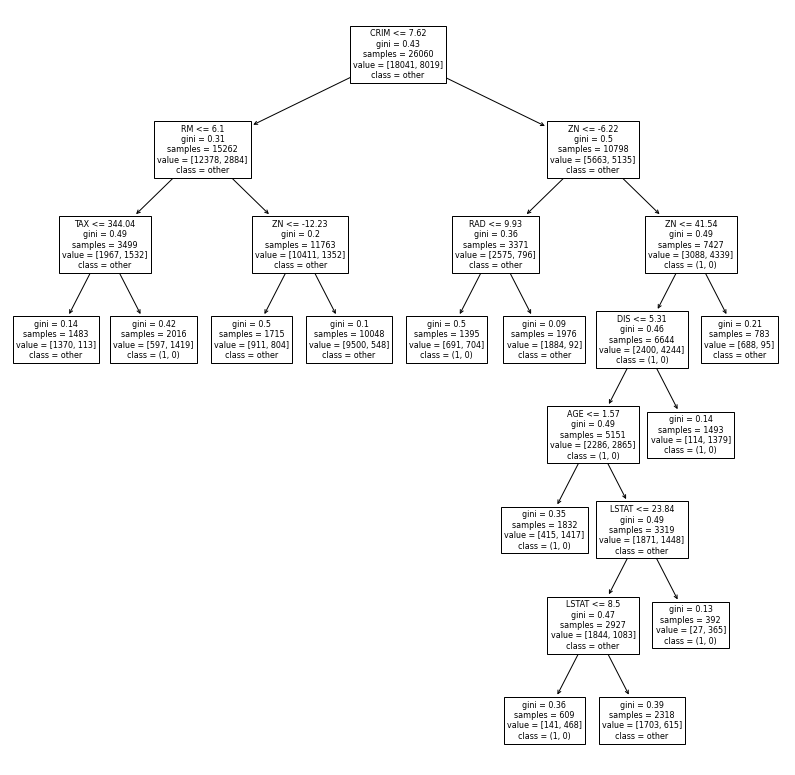

In [40]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [41]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
2. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [691, 704]
5. LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [141, 468]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]


### 13 Leafs

In [42]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007491494398159056, 7, 13)

In [43]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
2. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. LSTAT > 5.90 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [179, 560]
5. LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [141, 468]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]


### 15 Leafs

In [44]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.006546469136781129, 7, 15)

In [45]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
2. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. LSTAT > 5.90 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [179, 560]
5. LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [141, 468]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]
7. LSTAT > 14.58 and ZN > -12 and CRIM <= 7.6 and RM > 6.10 and RAD <= -2.25 => (1, 0) [31, 243]


### 16 Leafs

In [46]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.006544638011954856, 8, 16)

In [47]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [597, 1419]
2. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. LSTAT > 5.90 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [179, 560]
5. 7.37 < LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [19, 463]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]
7. LSTAT > 14.58 and ZN > -12 and CRIM <= 7.6 and RM > 6.10 and RAD <= -2.25 => (1, 0) [31, 243]


### 17 Leafs

In [48]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0063735344085529624, 8, 17)

In [49]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
2. 3.2 < CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [326, 1318]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. LSTAT > 5.90 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [179, 560]
5. 7.37 < LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [19, 463]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]
7. LSTAT > 14.58 and ZN > -12 and CRIM <= 7.6 and RM > 6.10 and RAD <= -2.25 => (1, 0) [31, 243]


### 18 Leafs

In [50]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0058997623018556475, 8, 18)

In [51]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
2. 3.2 < CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [326, 1318]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. 5.90 < LSTAT <= 9.01 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [47, 550]
5. 7.37 < LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [19, 463]
6. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]
7. LSTAT > 14.58 and ZN > -12 and CRIM <= 7.6 and RM > 6.10 and RAD <= -2.25 => (1, 0) [31, 243]


### 19 Leafs

In [52]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0057753388181180825, 8, 19)

In [53]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE <= 2 => (1, 0) [415, 1417]
2. 3.2 < CRIM <= 7.6 and RM <= 6.10 and TAX > 344 => (1, 0) [326, 1318]
3. -6 < ZN <= 42 and CRIM > 7.6 and DIS > 5.31 => (1, 0) [114, 1379]
4. 5.90 < LSTAT <= 9.01 and ZN <= -6 and CRIM > 7.6 and RAD <= 9.93 => (1, 0) [47, 550]
5. 7.37 < LSTAT <= 8.50 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [19, 463]
6. 8.50 < LSTAT <= 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and RM <= 5.83 and DIS <= 5.31 and AGE > 2 => (1, 0) [169, 290]
7. LSTAT > 23.84 and -6 < ZN <= 42 and CRIM > 7.6 and DIS <= 5.31 and AGE > 2 => (1, 0) [27, 365]
8. LSTAT > 14.58 and ZN > -12 and CRIM <= 7.6 and RM > 6.10 and RAD <= -2.25 => (1, 0) [31, 243]


In [54]:
from util import get_complexity

In [55]:
get_complexity(constraints)

Rules           8
Constraints    44
dtype: int64

## $(1,2)$

In [56]:
focus_class = '(1, 2)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [57]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

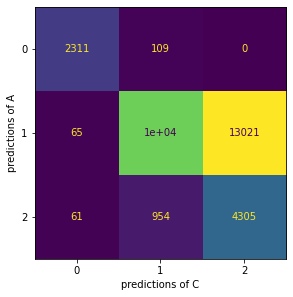

In [58]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-12.pdf')

In [59]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 1min 9s, sys: 460 ms, total: 1min 9s
Wall time: 1min 13s


362

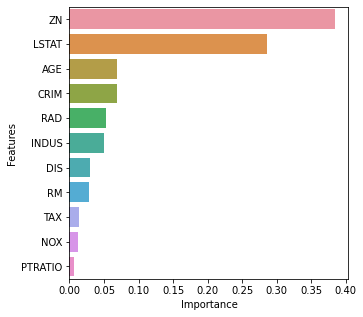

In [60]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

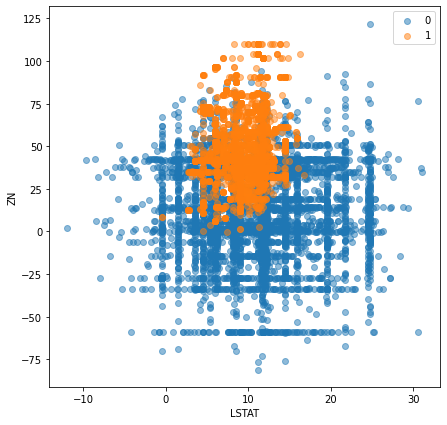

In [61]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [45]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07037882762220427, 1, 2)

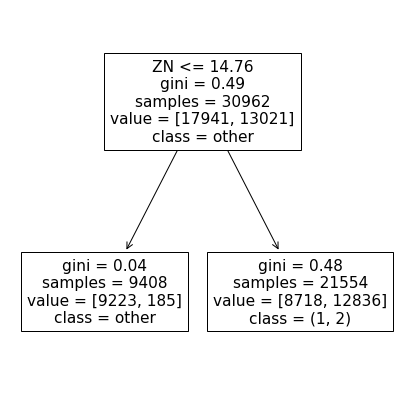

In [46]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [47]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 15 => (1, 2) [8718, 12836]


### 3 Leafs

In [48]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.03796445320005154, 2, 3)

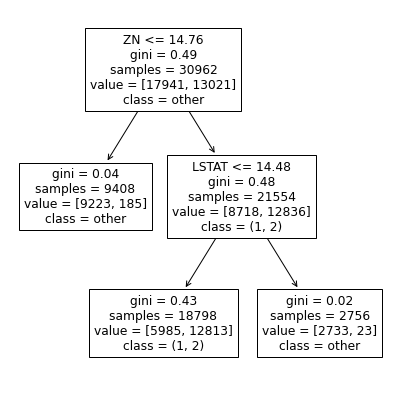

In [49]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [50]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 15 and LSTAT <= 14.48 => (1, 2) [5985, 12813]


### 4 Leafs

In [51]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.025041631344524, 3, 4)

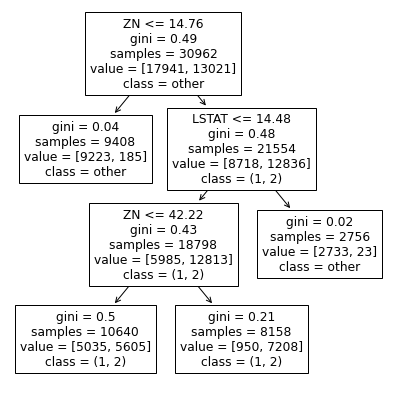

In [52]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [53]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 15 < ZN <= 42 and LSTAT <= 14.48 => (1, 2) [5035, 5605]
2. ZN > 42 and LSTAT <= 14.48 => (1, 2) [950, 7208]


### 5 Leafs

In [54]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.020235002450197048, 4, 5)

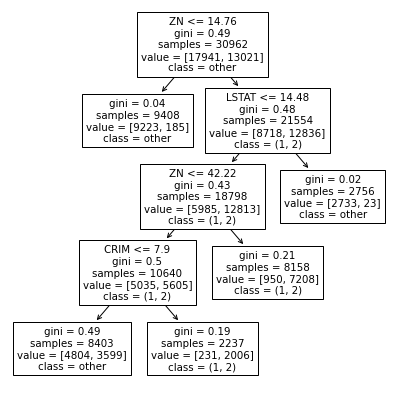

In [55]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [56]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42 and LSTAT <= 14.48 => (1, 2) [950, 7208]
2. 15 < ZN <= 42 and LSTAT <= 14.48 and CRIM > 7.9 => (1, 2) [231, 2006]


### 7 Leafs

In [57]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.01892509952509975, 6, 7)

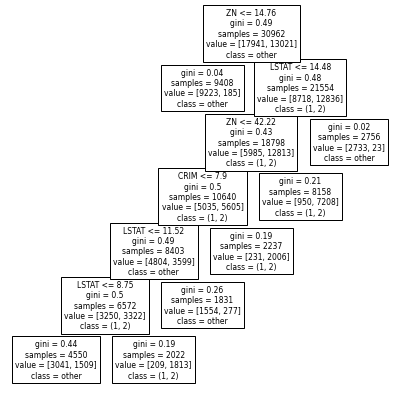

In [58]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [59]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42 and LSTAT <= 14.48 => (1, 2) [950, 7208]
2. 15 < ZN <= 42 and LSTAT <= 14.48 and CRIM > 7.9 => (1, 2) [231, 2006]
3. 15 < ZN <= 42 and 8.75 < LSTAT <= 11.52 and CRIM <= 7.9 => (1, 2) [209, 1813]


### 8 Leafs

In [60]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.009485846580884992, 6, 8)

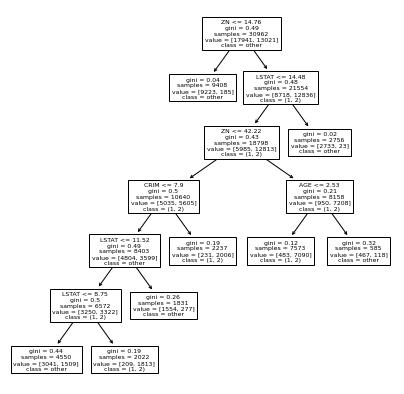

In [61]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [62]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. ZN > 42 and LSTAT <= 14.48 and AGE <= 3 => (1, 2) [483, 7090]
2. 15 < ZN <= 42 and LSTAT <= 14.48 and CRIM > 7.9 => (1, 2) [231, 2006]
3. 15 < ZN <= 42 and 8.75 < LSTAT <= 11.52 and CRIM <= 7.9 => (1, 2) [209, 1813]


## $(2,1)$

In [62]:
focus_class = '(2, 1)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [63]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

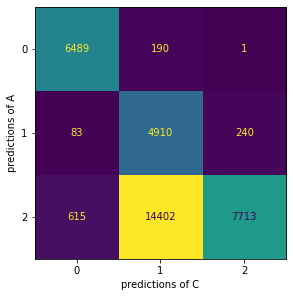

In [64]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/boston4-diro2c-cf-21.pdf')

In [65]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 2min 9s, sys: 1.56 s, total: 2min 10s
Wall time: 2min 28s


535

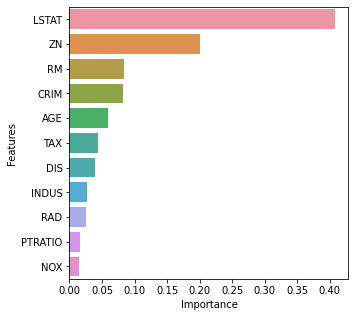

In [67]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

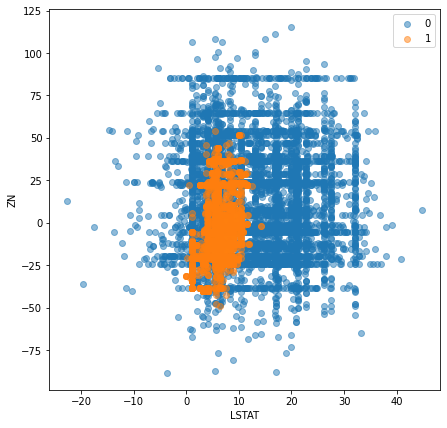

In [68]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### 2 Leafs

In [69]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07283219940974339, 1, 2)

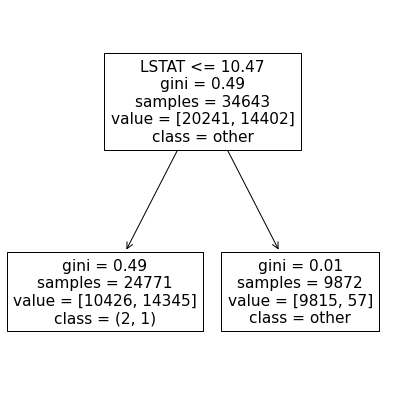

In [70]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [71]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. LSTAT <= 10.47 => (2, 1) [10426, 14345]


### 5 Leafs

In [72]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.02132784731827797, 4, 5)

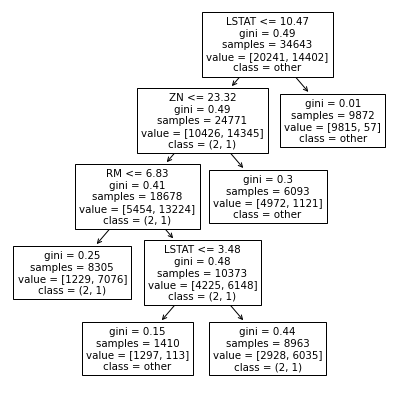

In [73]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [74]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. 3.48 < LSTAT <= 10.47 and ZN <= 23 and RM > 6.83 => (2, 1) [2928, 6035]
2. LSTAT <= 10.47 and ZN <= 23 and RM <= 6.83 => (2, 1) [1229, 7076]


# Additional Material

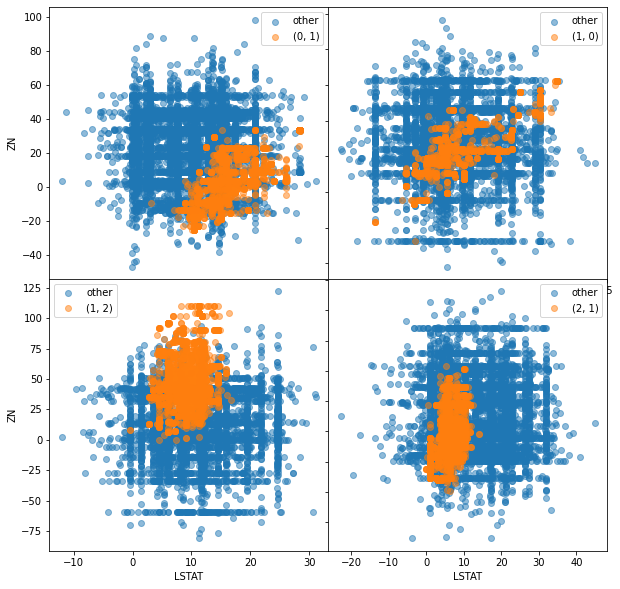

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    plot_diro2c_2d(explanation, 'LSTAT', 'ZN', ax=ax, class_names=['other', label])
    if label in ['(1, 0)', '(2, 1)']:
        ax.set_yticklabels([])
        ax.set_ylabel('')
plt.subplots_adjust(wspace=.0, hspace=0)
plt.savefig('figures/boston4-diro2c-scatter.png', bbox_inches='tight')

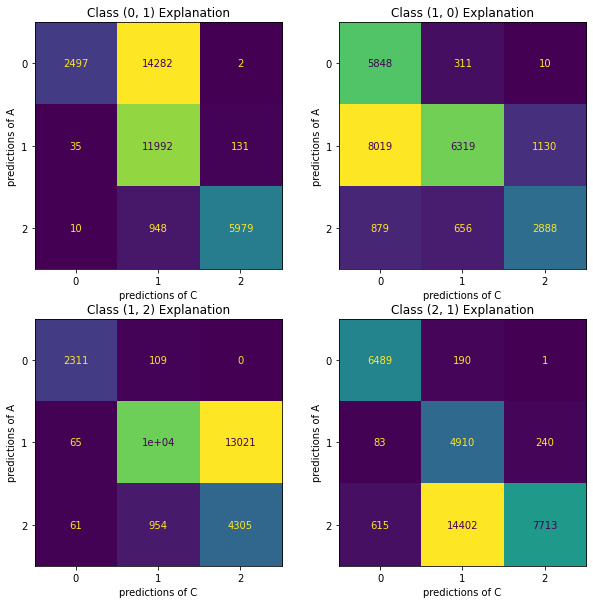

In [5]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
for label, ax in zip(['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)'], axs.flat):
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    comparer.plot_confusion_matrix(get_generated_data(explanation)[0], ax=ax)
    ax.set_title(f'Class {label} Explanation')
plt.savefig('figures/boston4-diro2c-cm.pdf', bbox_inches='tight')

In [68]:
n_constraints = 0
for label, n_leafs in [
    ('(0, 1)', 4),
    ('(1, 0)', 4),
    ('(1, 2)', 3),
    ('(2, 1)', 5)
]:
    with open(f'explanations/diro2c.{label}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    trees = get_pruned_trees(explanation)
    _, feature_order = get_feature_importances(trees[-1])
    tree = [tree for tree in trees if tree.get_n_leaves() == n_leafs][0]
    constraints, rules, class_occurences, labels, rule_order =\
        extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions, latex=True)
    for rule in rules:
        print(f'\item if ${rule}$, then ${label}$')
    n_constraints += get_complexity(constraints)[1]
print(n_constraints)

\item if $\text{ZN} \leq 23 \land \text{LSTAT} > 8.62 \land \text{TAX} \leq 603$, then $(0, 1)$
\item if $\text{CRIM} \leq 7.6 \land \text{RM} \leq 6.10 \land \text{TAX} > 344$, then $(1, 0)$
\item if $\text{ZN} > 15 \land \text{LSTAT} \leq 14.48$, then $(1, 2)$
\item if $3.48 < \text{LSTAT} \leq 10.47 \land \text{ZN} \leq 23 \land \text{RM} > 6.83$, then $(2, 1)$
\item if $\text{LSTAT} \leq 10.47 \land \text{ZN} \leq 23 \land \text{RM} \leq 6.83$, then $(2, 1)$
15
